In [16]:
from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [17]:
PATH_CLEAN = Path("Clean")

In [18]:
def print_entire_df(df):
    with pl.Config() as cfg:
        cfg.set_tbl_rows(-1) # Display all rows
        cfg.set_tbl_cols(-1) # Display all columns
        cfg.set_tbl_width_chars(999)
        print(df)

In [19]:
rateclasses = {}

for path in PATH_CLEAN.iterdir():
    if path.name == "weather_with_conditions.csv" :
        continue

    df = (
        pl.read_csv(path, try_parse_dates=True)
    )

    rateclasses[path.stem] = df

In [20]:
weather = pl.read_csv(PATH_CLEAN / "weather_with_conditions.csv", try_parse_dates=True)
weather

Date,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precipitation,Difference,snowy,cloudy,windy,sunny,stormy
datetime[μs],f64,f64,f64,str,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64
2019-01-01 01:00:00,40.0,25.0,0.55,"""NNW""",8.0,0.0,30.15,0.0,0,0,1,0,0,0
2019-01-01 02:00:00,46.0,46.0,1.0,"""CALM""",0.0,0.0,29.73,0.1,60,0,0,0,0,1
2019-01-01 03:00:00,47.0,46.0,0.97,"""CALM""",0.0,0.0,29.67,0.0,60,0,0,0,0,1
2019-01-01 04:00:00,47.0,47.0,1.0,"""WNW""",6.0,0.0,29.63,0.0,60,0,1,0,0,0
2019-01-01 05:00:00,51.0,51.0,1.0,"""WSW""",10.0,0.0,29.6,0.0,60,0,0,0,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-31 20:00:00,50.0,41.0,0.71,"""ENE""",9.0,0.0,29.7,0.0,60,0,1,0,0,0
2024-12-31 21:00:00,50.0,40.0,0.68,"""NE""",10.0,0.0,29.65,0.0,60,0,1,0,0,0
2024-12-31 22:00:00,46.0,42.0,0.86,"""NNE""",9.0,0.0,29.58,0.0,60,0,0,0,0,1


In [21]:
def get_data(rc):
    data = (
            weather
            .select(
                "Date",
                "Temperature"
            )
            .join(rc, on="Date")
            .with_columns(
                pl.col("Date").dt.time().dt.hour().alias("Hour"),
                pl.col("Temperature").pow(2).alias("Temperature^2")
            )
            .with_columns(
                pl.col("Hour")
            )
    )
    return data

get_data(rateclasses["RES"])

Date,Temperature,Load,Hour,Temperature^2
datetime[μs],f64,f64,i8,f64
2022-06-01 01:00:00,71.0,1758.08324,1,5041.0
2022-06-01 02:00:00,68.0,1434.04939,2,4624.0
2022-06-01 03:00:00,65.0,1391.249002,3,4225.0
2022-06-01 04:00:00,65.0,1173.145301,4,4225.0
2022-06-01 05:00:00,64.0,844.098606,5,4096.0
…,…,…,…,…
2024-05-31 20:00:00,75.0,2120.606159,20,5625.0
2024-05-31 21:00:00,74.0,2123.317578,21,5476.0
2024-05-31 22:00:00,72.0,2099.05341,22,5184.0


/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


GSC MAE 53.485118399010176
GSC MAPE 0.0524936289828983
GSC MSE 11493.461340631338


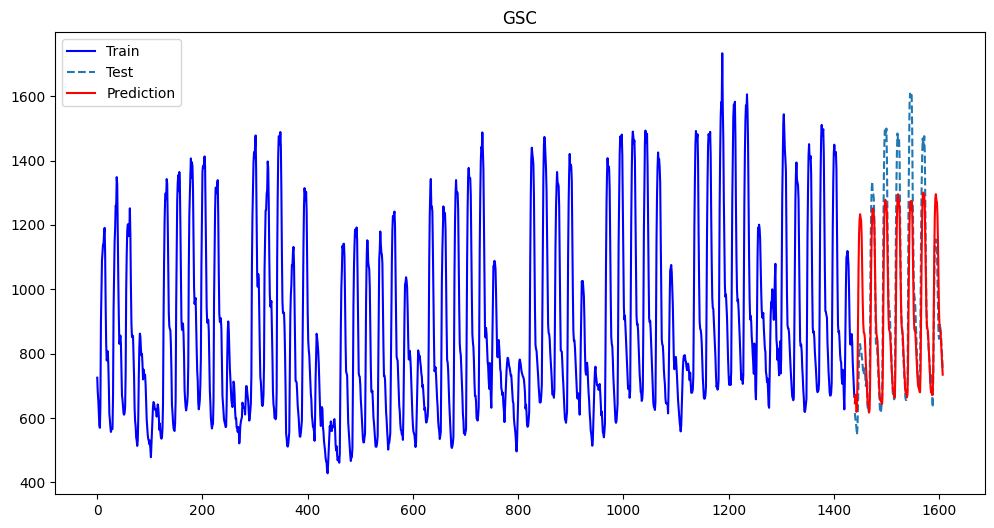

/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RES MAE 187.4390900402222
RES MAPE 0.11533123506668581
RES MSE 89752.72798189048


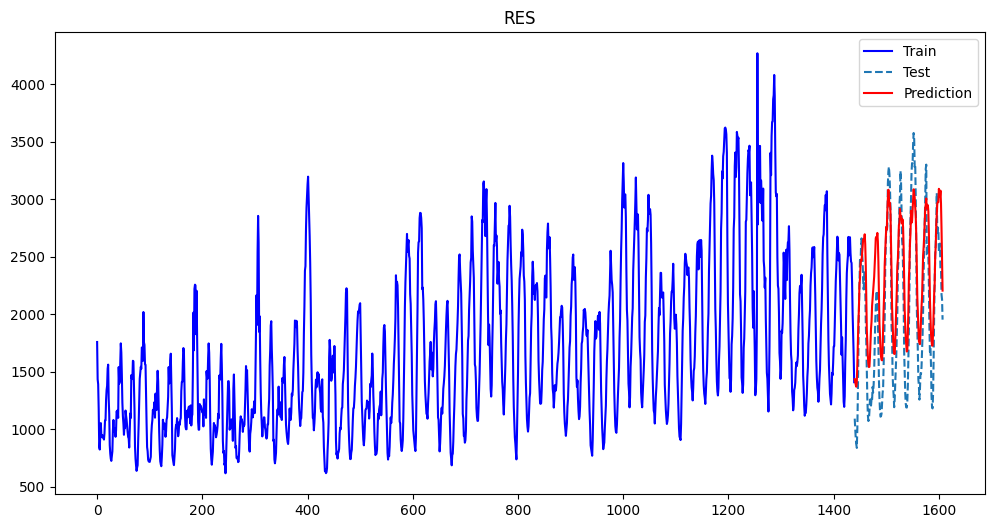

/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


GPI MAE 2.942314817320934
GPI MAPE 0.046370397381623796
GPI MSE 24.199398648428947


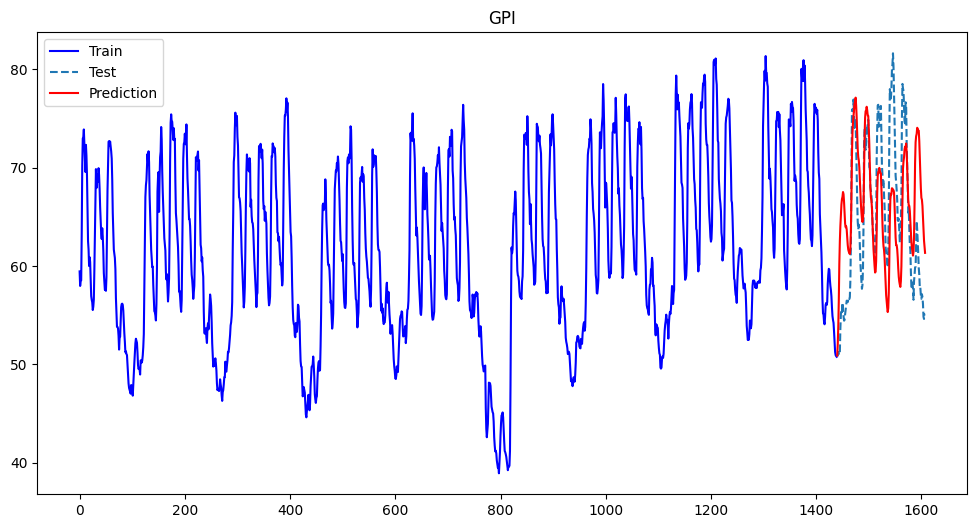

/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RSCP MAE 59.70771267154633
RSCP MAPE 0.03091836397500109
RSCP MSE 10199.481525352956


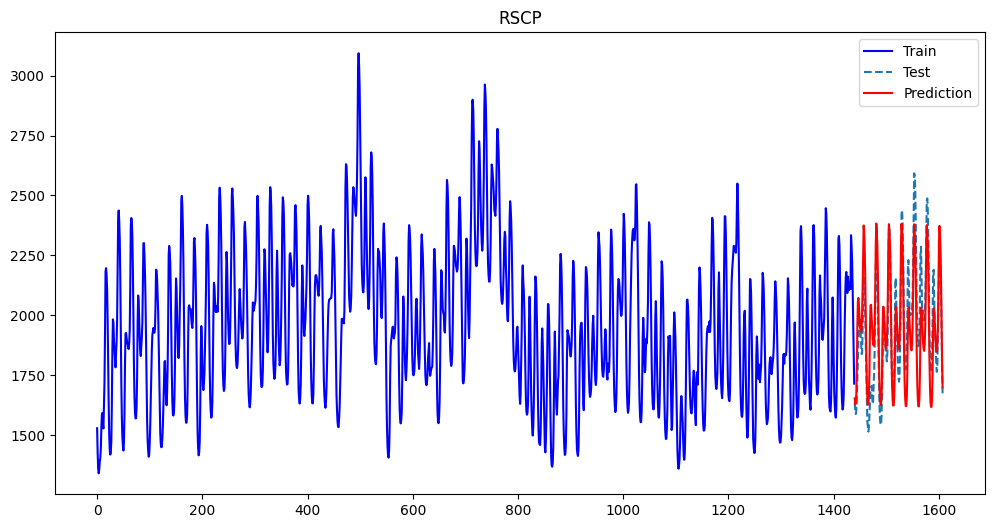

GSTC MAE 3.262126057422272
GSTC MAPE 0.05074590440833162
GSTC MSE 31.052820471270078


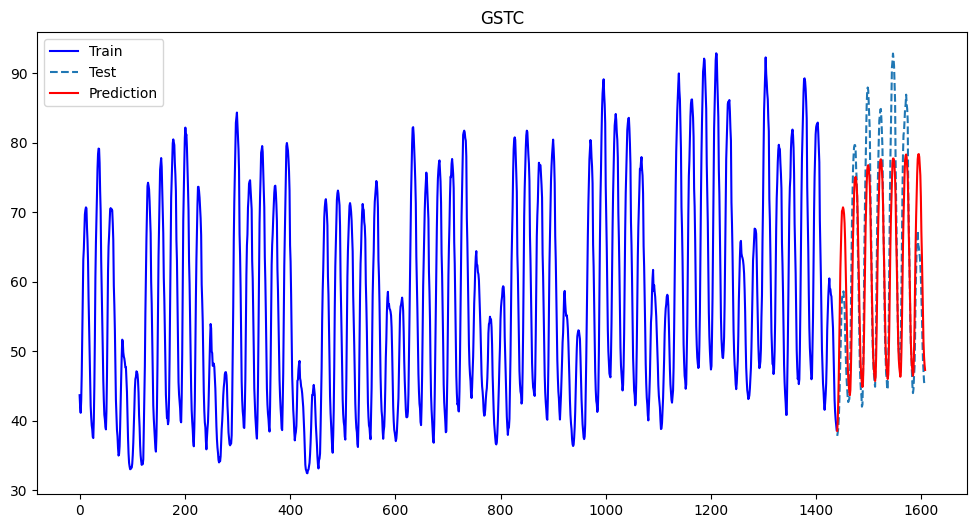

/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


GTC MAE 2.2790850765766595
GTC MAPE 0.02406954621143354
GTC MSE 15.673786195762519


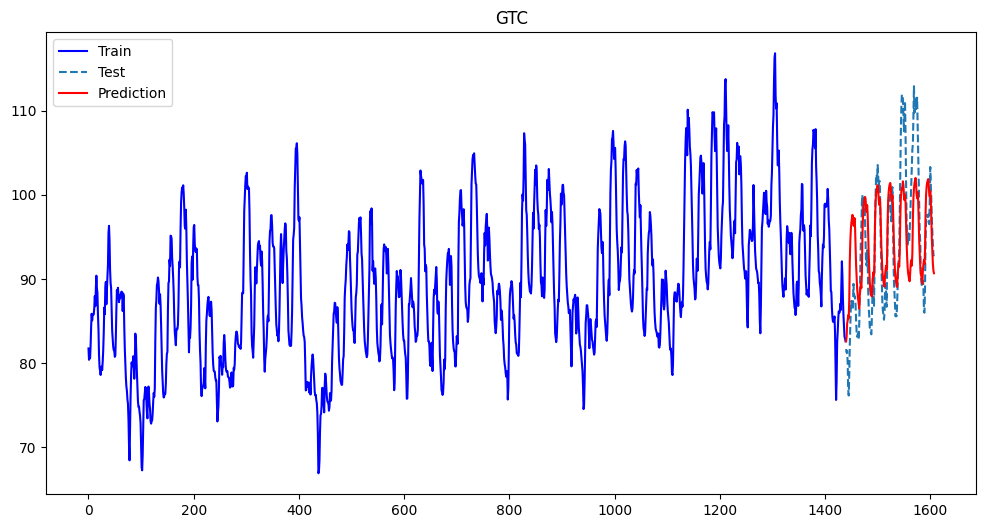

GSTI MAE 1.6696362832207765
GSTI MAPE 0.12353420384627983
GSTI MSE 6.587024513687921


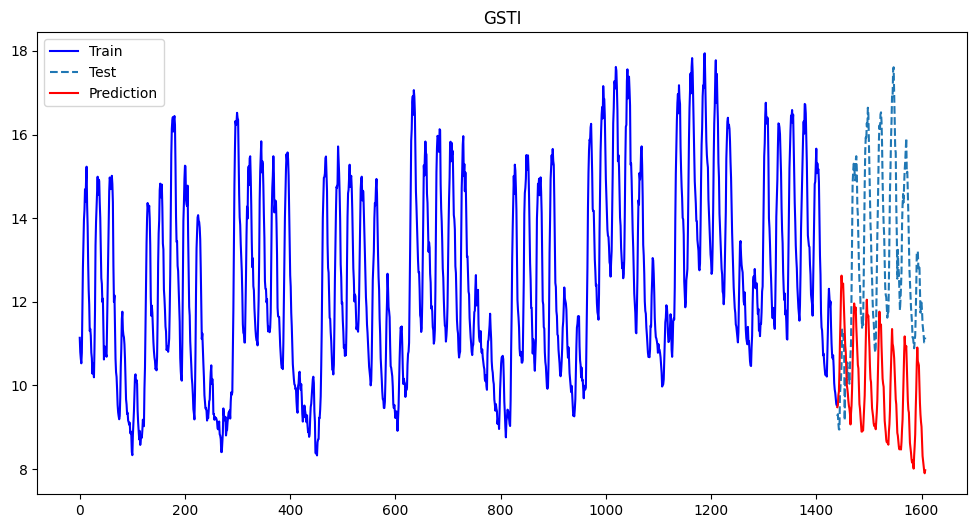

/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


GTI MAE 14.04074495886625
GTI MAPE 0.10129682347226497
GTI MSE 561.4092749654819


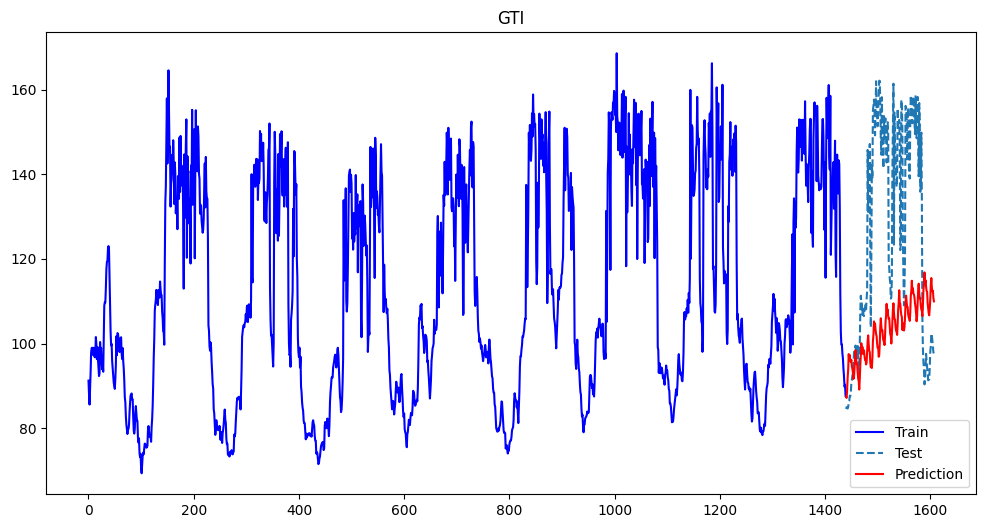

/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


GSI MAE 6.283708738010468
GSI MAPE 0.09982625849578751
GSI MSE 109.57614167444999


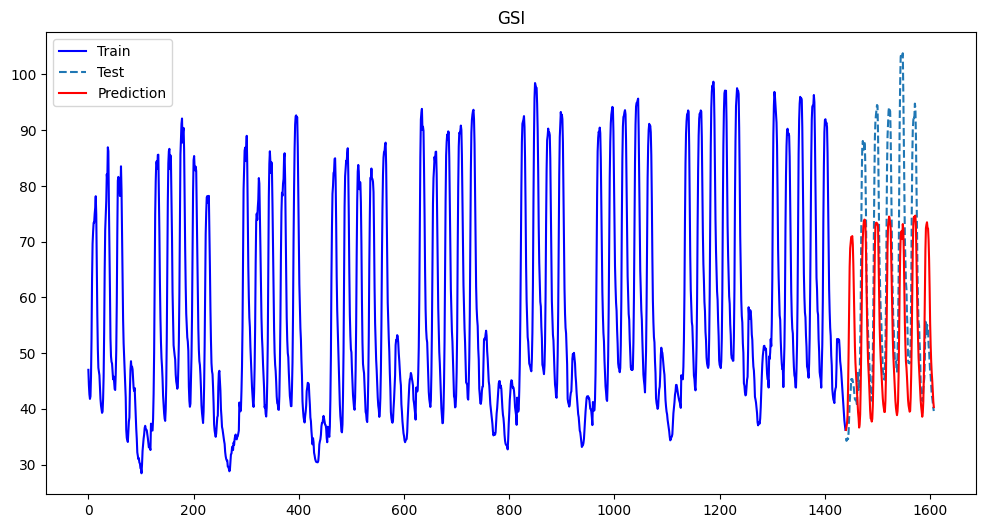

/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CIEP MAE 33.778741158067476
CIEP MAPE 0.05962448511682502
CIEP MSE 2781.1781913483414


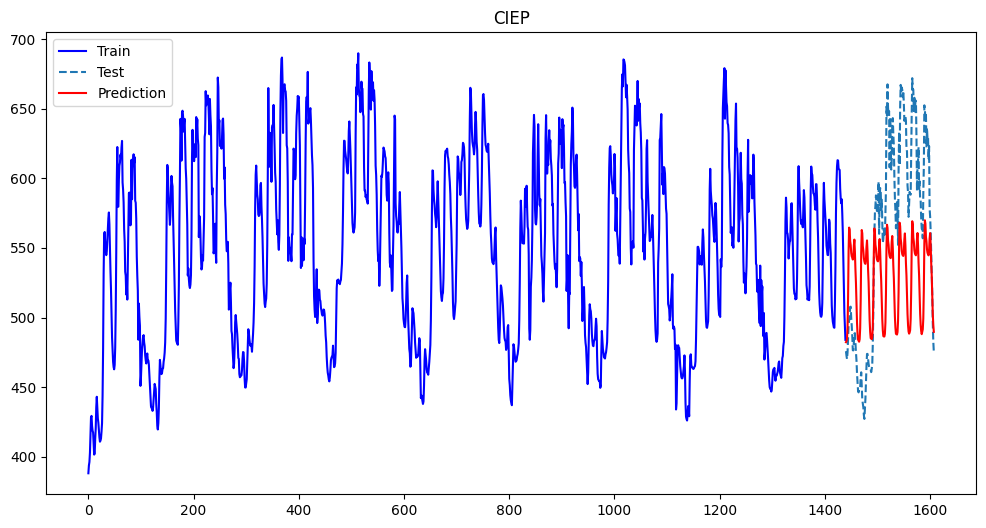

/Users/andytieu/Desktop/ds340w-project/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


GPC MAE 5.290535580339234
GPC MAPE 0.04188358920063269
GPC MSE 76.33572720295976


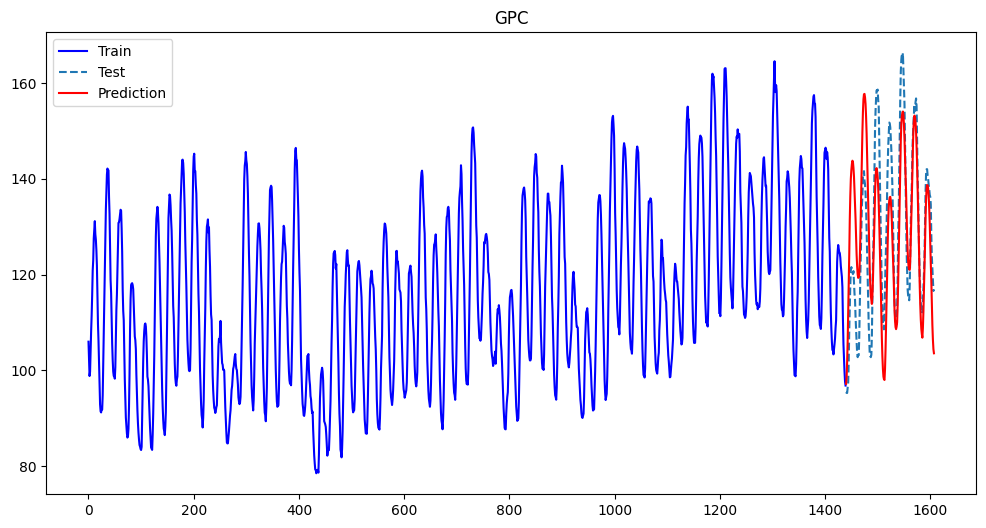

Average MAE 33.652619434600254
Average MAPE 0.06782676692343312
Average MSE 56.403710582171726


In [24]:
from sktime.forecasting.sarimax import SARIMAX

TRAIN_SIZE = 60 * 24
TEST_SIZE = 7 * 24
SHOW_PLOT = True
TEST_RUN = False

avg_mae = 0
avg_mape = 0
avg_rmse = 0

sarimax = SARIMAX(
    order=(2, 0, 2), 
    seasonal_order=(1, 1, 1, 24), 
)

for name, rc in rateclasses.items():
    data = get_data(rc)

    X = data.select("Temperature", "Temperature^2")
    y = data.select("Load")

    y_train, y_test, X_train, X_test = temporal_train_test_split(y=y, X=X, train_size=TRAIN_SIZE, test_size=TEST_SIZE) # type: ignore

    model = sarimax
    model.fit(y=y_train, X=X_train)
    y_pred: pl.DataFrame = model.predict(fh=np.arange(1, TEST_SIZE+1), X=X_test) # type: ignore

    y_train = y_train.rename({"__index__0": "Index"})
    y_test = y_test.rename({"__index__0": "Index"})
    y_pred = y_pred.rename({"__index__0": "Index", "0": "Load"})

    Y_joined = pl.concat([y_train, y_test]) # type: ignore

    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    print(name, "MAE", mae)
    print(name, "MAPE", mape)
    print(name, "MSE", mse)
    avg_mae += mae
    avg_mape += mape
    avg_rmse += np.sqrt(mse)
    
    if SHOW_PLOT:
        plt.figure(figsize=(12, 6))
        plt.plot(y_train["Index"], y_train["Load"], label="Train", color="Blue")
        plt.plot(y_test["Index"], y_test["Load"], label="Test", linestyle='dashed')
        plt.plot(y_pred["Index"], y_pred["Load"], label="Prediction", color="Red")
        plt.legend()
        plt.title(name)
        plt.show()

    if TEST_RUN:
        break

avg_mae /= len(rateclasses)
avg_mape /= len(rateclasses)
avg_rmse /= len(rateclasses)

print("Average MAE", avg_mae)
print("Average MAPE", avg_mape)
print("Average MSE", avg_rmse)